# Проект

# Прогнозирование заказов такси

**Цель проекта:**

Оптимизировать количество привлекаемых водителей в период пиковой нагрузки, прогнозируя количество заказов на следующий час.

## Описание проекта

**Импорт библиотек.**

**Подготовка данных**

Данные загружены и обработаны:

* Данные соответствуют описанию.
* Пропусков нет.

**Анализ данных**

Проведен исследовательский анализ данных:

* Построена гистограмма распределения
* Построена диаграмма размаха
* Проведены тесты на нормальность распределения признака

Данные ресемплированы по часам и по дням

Определены тренд и параметры сезонности по месяцам, дням недели и часам

**Обучение моделей**

Данные разбиты на выборки

Рассмотрены:
* Прогноз по медиане
* Прогноз по предыдущему значению
* LinearRegression
* ElasticNet
* DescisionTreeRegressor
* CatBoostRegressor
* LGBMRegressor

**Тестирование**

## Импорт библиотек

In [1]:
!pip install --upgrade scikit-learn=='1.4.0' -q # от падучей болезни Юпитера

In [2]:
!pip install lightgbm -q

In [3]:
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import statsmodels.api as sm
import matplotlib.colors as colors

In [4]:
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, root_mean_squared_error)
from matplotlib import pyplot as plt
from scipy.stats import lognorm, shapiro, normaltest, anderson, uniform, pearsonr
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import tree
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [5]:
from datetime import datetime, date

In [6]:
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool, cv
from lightgbm import LGBMRegressor

In [7]:
import time
import catboost as cb
import lightgbm as lgb

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import ElasticNet, Lasso, Ridge

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm

In [11]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [12]:
# Зададим отображение десятичных знаков

pd.options.display.float_format = '{:.3f}'.format

In [13]:
# Зададим Random State

RANDOM_STATE = 45

In [14]:
# И уберем сразу эти бесячие красные квадратики

import warnings 
warnings.filterwarnings('ignore')

## Подготовка

### Загрузка данных

In [15]:
# Загружаем файлы
# Даты сразу сделаем индексами файла

df = pd.read_csv(
    'https://code.s3.yandex.net//datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [16]:
# Отсортируем даты

df.sort_index(inplace=True)

Выведем первые 5 строк

In [17]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [18]:
# Дата начала периода

df.index.min()

Timestamp('2018-03-01 00:00:00')

In [19]:
# Дата конца периода

df.index.max()

Timestamp('2018-08-31 23:50:00')

In [20]:
# Сохраним на всякий случай размер исходного файла

size_origin = df.shape[0]

Рассматриваемый период: с марта по август 2018 года.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные в колонке заполнены, соответствуют описанию, пропусков нет.

In [22]:
# Выведем описание данных

df.describe()

,num_orders
count,26496.000
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000


Явных аномалий на первый взгляд нет. Среднее количество заказов = 14, максимальное 119. Распределение по квартилям: 8-13-19.

In [23]:
# Проверим значения

df.num_orders.unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67])

In [24]:
df[df['num_orders']>=119].count()

num_orders    2
dtype: int64

## Анализ

### Исследовательский анализ данных

In [25]:
# Ресемплируем данные по дням

df = df.resample('1H').sum()

In [26]:
# Размер файла

df.shape[0]

4416

Медиана признака = 78.0


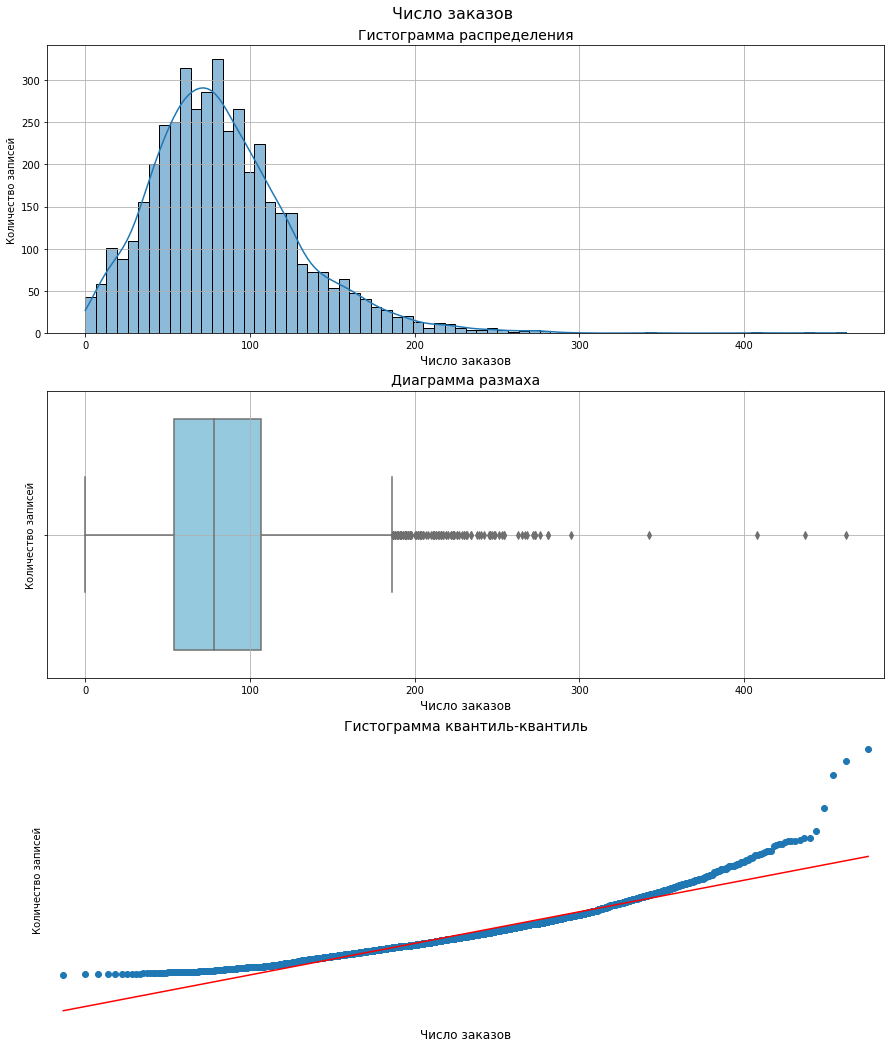

In [27]:
# Визуализируем распределение признака

fig, axes = plt.subplots(3,1, figsize=(15,18))
fig.suptitle(f"Число заказов", size=16, y=0.91)

sns.histplot(x=df.num_orders, ax=axes[0], kde=True, bins='auto');

axes[0].set_title(f'Гистограмма распределения', fontsize=14)
axes[0].set_xlabel('Число заказов', fontsize=12)
axes[0].set_ylabel('Количество записей')
axes[0].grid()

sns.boxplot(x=df.num_orders, color='SkyBlue', ax=axes[1])
axes[1].set_title('Диаграмма размаха', fontsize=14)
axes[1].set_xlabel('Число заказов', fontsize=12)
axes[1].set_ylabel('Количество записей')
axes[1].grid()

qqplot(data=df.num_orders, ax=axes[2], line='s') 
axes[2].set_title(f'Гистограмма квантиль-квантиль', fontsize=14)
axes[2].set_xlabel('Число заказов', fontsize=12) 
axes[2].set_ylabel('Количество записей')
axes[2].grid()

plt.box(False)  
plt.xticks([])

plt.yticks([])

fig.show()  

print(f'Медиана признака = {np.median(df.num_orders)}')

In [28]:
# Приоверим нормальность распределения признака

print(f'Тест Шапиро-Уилка = {shapiro(df.num_orders)}')
if shapiro(df.num_orders)[1] > 0.05:
    print("Есть основания полагать, что данные распределены нормально", '\n')
else:
    print("Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.", '\n')
    
print(f'Тест Д Агостино = {normaltest(df.num_orders)}')
if normaltest(df.num_orders)[1] > 0.05:
    print("Есть основания полагать, что данные распределены нормально", '\n')
else:
    print("Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.", '\n')
    
print(f'Коэффициент асимметрии = {df.num_orders.skew()}')
if df.num_orders.skew() < 0:
    print("Отрицательная асимметрия: хвост находится в левой части.")
    print("Распределение простирается в сторону более отрицательных значений.")
elif df.num_orders.skew() == 0:
    print("Нулевая ассиметрия: распределение совершенно симметрично.")
else:
    print("Положительная асимметрия: хвост находится в правой части.")
    print("Распределение простирается в сторону положительных значений.")

Тест Шапиро-Уилка = ShapiroResult(statistic=0.9420170187950134, pvalue=1.5791201565910148e-38)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=1063.6679695449006, pvalue=1.0652097298119359e-231)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = 1.1889555732379704
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону положительных значений.


Визуально и на основе тестов можем отметить, что признак не распределен нормально.

Медиана составляет 13 заказов в час. Значения ~ от 38 заказов в час относятся к выбросам.

Но удалять здесь мы ничего не будем, поскольку такие значения зафиксированы, и модель должна уметь просчитывать в т.ч. такие существенные приросты признака.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [30]:
# Проверим стационарность ряда

result = adfuller(df['num_orders'])
print('ADF статистика:', result[0])
print('p-value:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')
    
if result[1] < 0.05:
    print('\n', 'p-value меньше 0.05, можно считать временной ряд стационарным')
else:
    print('\n', 'p-value больше 0.05, временной ряд нельзя считать стационарным')

ADF статистика: -3.0689242890279558
p-value: 0.028940051402612906
Критические значения:
  1%: -3.431842162413052
  5%: -2.8621993540813637
  10%: -2.567120978470452

 p-value меньше 0.05, можно считать временной ряд стационарным


### Ресемплирование по часам

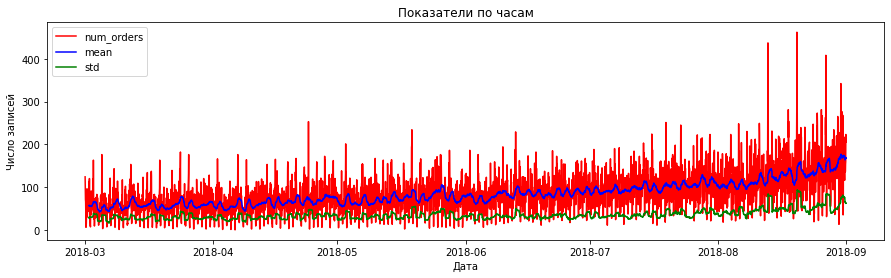

In [31]:
# На графике:

plt.figure(figsize=(15,4))
plt.plot(df.num_orders, label='num_orders', color='red')
plt.plot(df.num_orders.rolling(24).mean(), label='mean', color='blue')
plt.plot(df.num_orders.rolling(24).std(), label='std', color='green')

plt.legend()
plt.title('Показатели по часам')
plt.xlabel('Дата')
plt.ylabel('Число записей')
plt.show()

График показывает, что количество заказов в целом увеличивается с течением времени.

Хотя, возможно, в августе играют роль поездки отпускников, т.к. самый сезон отпусков.

Рассмотрим на графиках тренд, сезонность и остатки

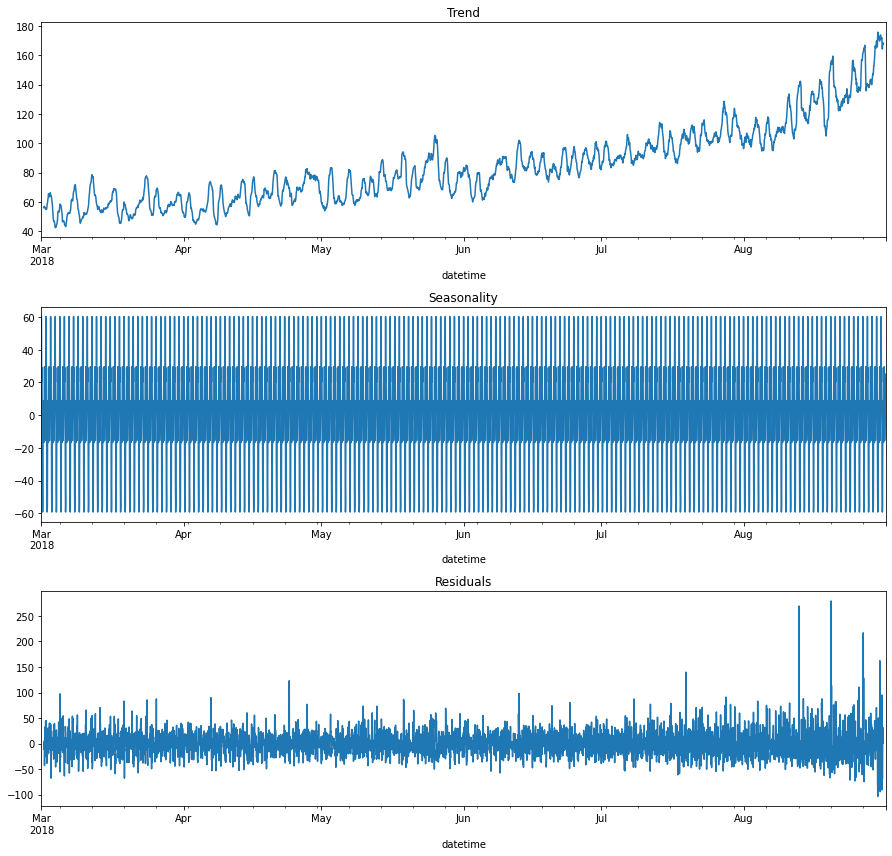

In [32]:
# На графике:

decomposed = seasonal_decompose(df.num_orders)

plt.figure(figsize=(12.5, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Рассмотрим сезонность за июль. 

Т.к. в августе (я еще подумала, и решила )) ) может быть сильное влияние отпускников. 

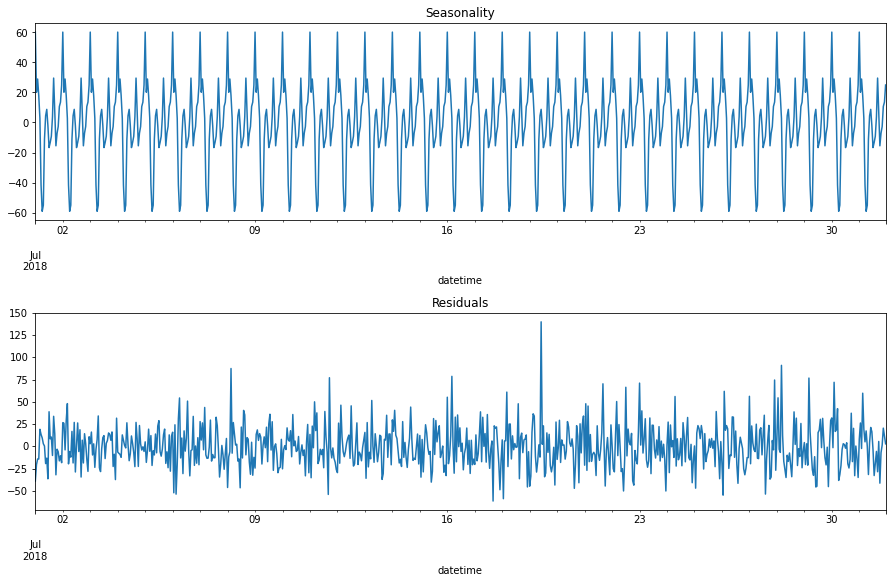

In [33]:
# Рассмотрим один месяц
# Возьмем для анализа последний месяц выборки, где количество поездок наибольшее

plt.figure(figsize=(12.5, 12))

plt.subplot(312)
decomposed.seasonal['2018-07':'2018-07'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-07':'2018-07'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

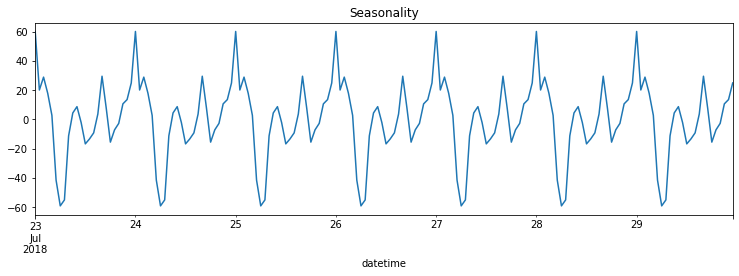

In [34]:
# Рассмотрим данные за последнюю полную неделю

plt.figure(figsize=(12.5, 12))

plt.subplot(312)
decomposed.seasonal['2018-07-23':'2018-07-29'].plot(ax=plt.gca())
plt.title('Seasonality');

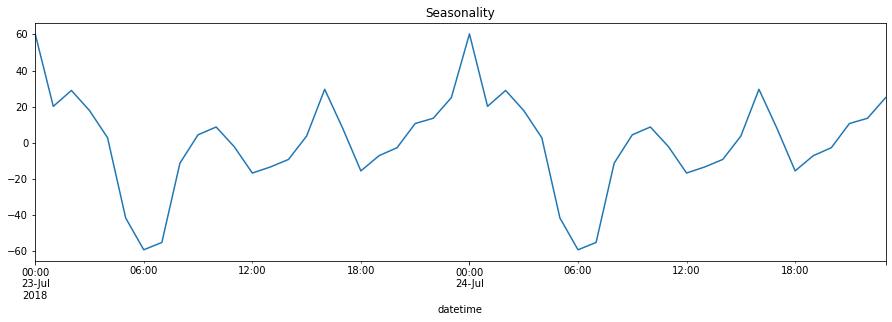

In [35]:
# Рассмотрим данные сезонности за сутки

plt.figure(figsize=(12.5, 12))

plt.subplot(312)
decomposed.seasonal['2018-07-23':'2018-07-24'].plot(ax=plt.gca())
plt.title('Seasonality');

plt.tight_layout()

Минимальное число поездок в 6 утра, максимальное в 00 часов.

Три периода роста активности: утро (9-11 часов), день (15 часов) и вечер (21-02 часов).

Три периода спада активности: раннее утро (5-7 часов), середина дня (12-14 часов), cередина вечера (18-20 часов)

### Ресемплирование по дням

In [36]:
# Ресемплируем данные по дням

df_days = df.resample('1D').sum()
df_days['mean'] = df.num_orders.rolling(15).mean()
df_days['std'] = df.num_orders.rolling(15).std()

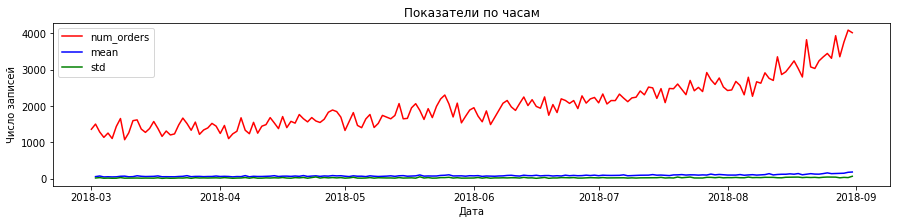

In [37]:
# На графике:

plt.figure(figsize=(15,3))
plt.plot(df_days.num_orders, label='num_orders', color='red')
plt.plot(df_days['mean'], label='mean', color='blue')
plt.plot(df_days['std'], label='std', color='green')

plt.legend()
plt.title('Показатели по часам')
plt.xlabel('Дата')
plt.ylabel('Число записей')
plt.show()

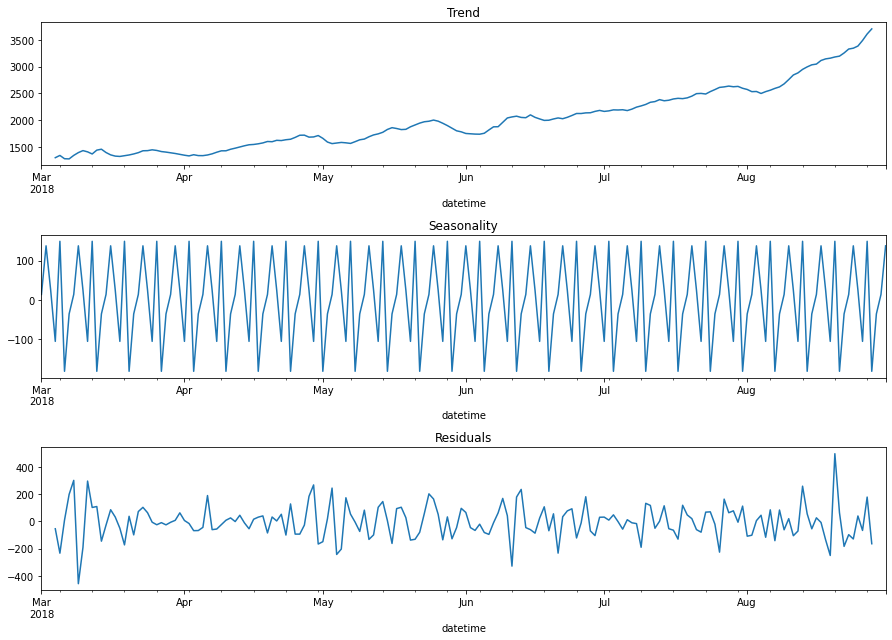

In [38]:
# На графике:

decomposed = seasonal_decompose(df_days.num_orders)

plt.figure(figsize=(12.5, 9))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

От марта к августу число поездок постоянно возрастает.
Показатель имеет выраженную сезонность.

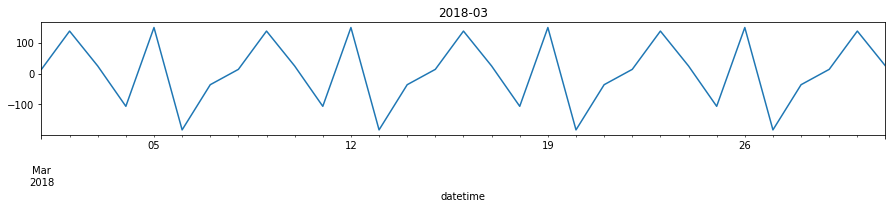

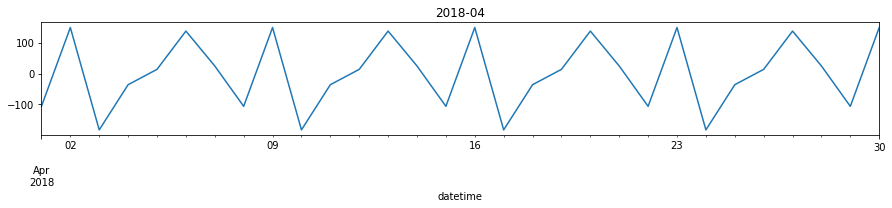

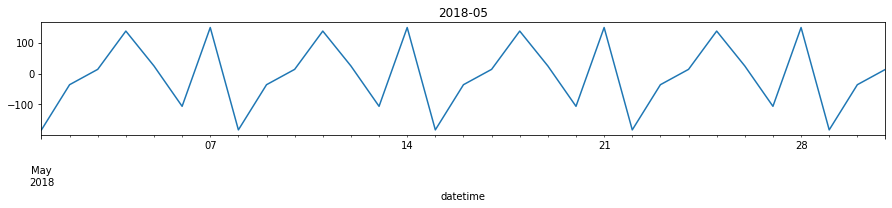

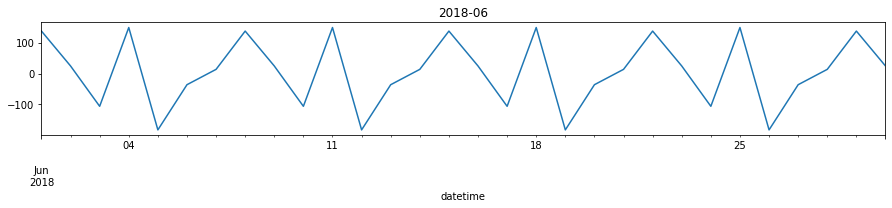

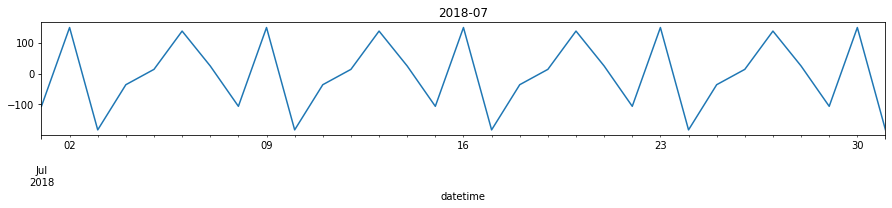

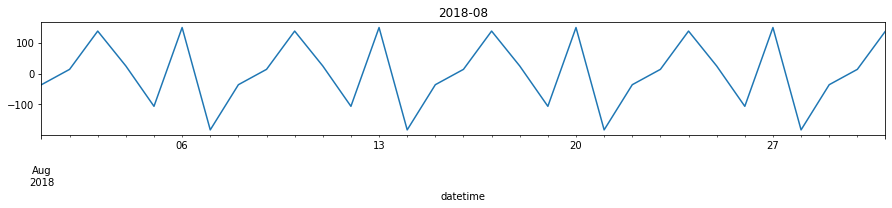

In [39]:
# Сезонность по месяцам:

dates_list = ['2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08']

for i, item in enumerate(dates_list):
    
    plt.figure(figsize=(12.5, 3))
    
    plt.subplot(111)
    decomposed.seasonal[dates_list[i]:dates_list[i]].plot(ax=plt.gca())
    plt.title(dates_list[i])

    plt.tight_layout()

Сезонность разных месяцев немного отличается.

Но в целом можно отметить:
* Наибольшее число поездок по понедельникам
* Наименьшее число поездок по вторникам и воскресеньям
* Повышение числа поездок в четверг и пятницу.

Т.о. анализ показывает суточную и недельную сезонность временного ряда.

## Обучение

In [40]:
#Разделим данные на выборки 
#Test_size = 10%, согласно заданию

train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [41]:
#Проверим размер выборок

print(f'Тренировочная выборка: {train.shape}')
print(f'Тестовая выборка: {test.shape}')

Тренировочная выборка: (3974, 1)
Тестовая выборка: (442, 1)


### Прогноз по медиане

In [42]:
print("Среднее число поездок в час:", round(df.num_orders.mean(), 4))

pred_median = np.ones(test.shape) * train.num_orders.median()

rmse_median = round(sqrt(mean_squared_error(test.num_orders, pred_median)),4)
print("RMSE median:", rmse_median)

Среднее число поездок в час: 84.4228
RMSE median: 87.1528


Метрика превышает заданную величину = 48.

### Прогноз по предыдущему значению

In [43]:
print("Среднее число поездок в час:", df.num_orders.mean())
pred_previous = round(test.shift(fill_value=df.num_orders.iloc[train.shape[0]-1]),4)
rmse_lag = round(sqrt(mean_squared_error(test.num_orders, pred_previous)),4)
print("RMSE:", rmse_lag)

Среднее число поездок в час: 84.42278079710145
RMSE: 58.8565


Метрика лучше, чем в первом варианте, но также превышает 48.

### Подготовка данных для работы моделей

In [44]:
# Создадим функцию для формирования новых признаков

def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year # год -то у нас один и тот же , не будем его добавлять
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    #data['weekday'] = pd.DatetimeIndex(data.index).to_series().dt.day_name()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.num_orders.shift(lag)

    data['rolling_mean'] = data.num_orders.shift().rolling(rolling_mean_size).mean()

In [45]:
# Добавим признаки в таблицу
df_feat = df.copy()

make_features(df_feat, 168, 168)
display(df_feat.head(3))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.000,124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Разобьем данные на выборки

train, test = train_test_split(df_feat, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

# Проверим размер выборок

print(f'Тренировочная выборка: {train.shape}')
print(f'Тестовая выборка: {test.shape}')

Тренировочная выборка: (3806, 172)
Тестовая выборка: (442, 172)


In [47]:
# Определим целевой и входящие признаки

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

###  Пайплайн и масштабирование

Определеим типы колонок

In [48]:
# Создадим список ранговых категориальных признаков и категории
# Судя по всему, они нам и не понадобятся, но пусть будут в списках

cat_ord_cols = []
cat_ord_cols_2 = ['dayofweek', 'hour']
categories = [[3, 4, 5, 6, 0, 1, 2], [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]]

In [49]:
# Создадим список числовых колонок

num_code_cols = df_feat.drop(['num_orders'], axis=1).select_dtypes(include='number').columns
len(num_code_cols)

171

In [50]:
# Проверим

len(df_feat.columns)

172

Поскольку категориальные признаки у нас выражены числами, можно их не кодировать

Объединим масштабирование в пайплайн с подготовкой данных = data_preprocessor.

In [51]:
# Создаем пайплайн для обработки данных

data_preprocessor = ColumnTransformer([('num', StandardScaler(), num_code_cols)],
                                      remainder='passthrough') 

Создадим пайплайн подготовки данных и обучения модели.

In [52]:
# Итоговый пайплайн: подготовка данных и модель Линейная регрессия

pipe = Pipeline([('preprocessor', data_preprocessor),
                 ('models', LinearRegression(fit_intercept=True))]) 

### Подбор линейных моделей и гиперпараметров

(Раз уж у нас есть пайплайн, то воспользуемся подбором гиперпараметров сразу для всех моделей)

In [53]:
# Зададим гиперпараметры пайплайна

param_distributions = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],     
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],  
        'models__alpha': np.arange(0.1, 1, 0.2), 
        'models__l1_ratio': np.arange(0.1, 1, 0.2), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
       
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__splitter': ['best','random'],
        'models__max_depth': range(1, 45),
        'models__min_samples_leaf': range(1, 45),
        'models__max_features': range(1, 7),
        'models__min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        'models__max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90,100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
        
    # словарь для модели RandomForestRegressor() 
    { 
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(1, 5), 
        'models__min_samples_leaf': range(1, 4), 
        'models__max_features': range(1, 7), 
        'models__n_estimators': range(1, 150), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [54]:
# Используем кросс-валидацию для временных рядов

tscv = TimeSeriesSplit(n_splits=5)

In [55]:
# Определим подбор параметров с помощью RSCV

pipe_model = RandomizedSearchCV(
    pipe, 
    param_distributions, 
    cv=tscv,
    scoring = 'neg_root_mean_squared_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
)

In [56]:
# Обучим модель

pipe_model.fit(X_train, y_train) 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8',
       ...
       'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag...
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestRegressor(random_state=45)],
                                         'models__max_depth': range(1, 5),
                                         'models__max_features': range(1, 7),
                                         'models__min_samples_leaf': range(1, 4),
                                         'models__n_estimators': range(1, 150),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=45, scoring='neg_root_mean_squared_error')

In [57]:
print(f'RMSE лучшей модели: {round(-pipe_model.best_score_,4)}')

RMSE лучшей модели: 39.6353


In [58]:
# Лучшая модель и ее параметры:

pipe_model.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__splitter': 'best',
 'models__min_weight_fraction_leaf': 0.2,
 'models__min_samples_leaf': 30,
 'models__max_leaf_nodes': 70,
 'models__max_features': 1,
 'models__max_depth': 4,
 'models': DecisionTreeRegressor(random_state=45)}

### Градиентный бустинг

In [59]:
# Зададим гиперпараметры пайплайна

param_distributions = [
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(cat_features="from_dtype")], 
        'models__depth': range(1, 6),
        'models__learning_rate': np.arange(0.1, 0.5, 0.1),
        'models__iterations': range(50, 550, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.1)],  
        'models__learning_rate': np.arange(0.1, 0.5, 0.1), 
        'models__n_estimators': range(50, 550, 50), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },    
    
    # словарь для модели HistGradientBoostingRegressor()
    {
        'models': [HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 6),
        'models__learning_rate': np.arange(0.1, 0.5, 0.1),
        'models__max_iter': range(50, 550, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [60]:
# Используем кросс-валидацию для временных рядов

tscv = TimeSeriesSplit(n_splits=5)

In [61]:
# Определим подбор параметров с помощью RSCV

pipe_boost = RandomizedSearchCV(
    pipe, 
    param_distributions, 
    cv=tscv,
    scoring = 'neg_root_mean_squared_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
)

In [62]:
# Обучим модель

pipe_boost.fit(X_train, y_train) 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8',
       ...
       'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag...
                                                               'passthrough']},
                                        {'models': [HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                                                  random_state=45)],
                                         'models__learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                                         'models__max_depth': range(1, 6),
                                         'models__max_iter': range(50, 550, 50),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=45, scoring='neg_root_mean_squared_error')

In [63]:
print(f'RMSE лучшей модели: {round(-pipe_boost.best_score_,4)}')

RMSE лучшей модели: 22.8103


In [64]:
# Лучшая модель и ее параметры:

pipe_boost.best_params_

{'preprocessor__num': 'passthrough',
 'models__max_iter': 150,
 'models__max_depth': 1,
 'models__learning_rate': 0.1,
 'models': HistGradientBoostingRegressor(categorical_features='from_dtype',
                               random_state=45)}

### Лучшая модель

In [65]:
#Соберем итоги

model_comparison = pd.DataFrame({'model_type': ['Linear', 'Boosting'],
                                 'rmse_train': [pipe_model.best_score_, pipe_boost.best_score_],
                                 'models': [pipe_model.best_estimator_[1], pipe_boost.best_estimator_[1]]
                                                                 
                                })

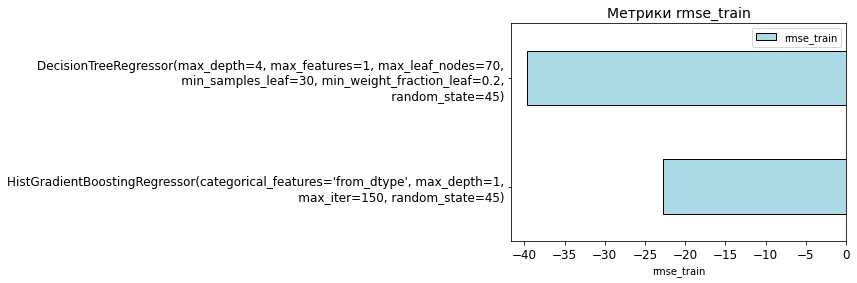

In [66]:
#Визуализация
model_comparison.sort_values('rmse_train', ascending=False).plot(
    x='models', y='rmse_train', kind='barh', color='LightBlue', edgecolor='black');

#Как убрать это сообщение вверху графика - не знаю, точки с запятой наставила везде, оно все равно появляется

plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('rmse_train'); plt.xticks(size = 12);
plt.title('Метрики rmse_train', size = 14);

In [67]:
#Лучшей моделью  по валидационной метрике получается:

best_model_valid = model_comparison.sort_values(by = ['rmse_train'], ascending=False).head(1)
best_model_valid

,model_type,rmse_train,models
1,Boosting,-22.810,HistGradientBoostingRegressor(categorical_feat...


## Тестирование

In [68]:
# Получим предсказание лучшей по мтерике модели

pred = best_model_valid.iloc[0]['models'].predict(X_test)

# Выведем метрику

rmse = round(np.sqrt(mean_squared_error(y_test, pred)), 4)
print(f'RMSE {best_model_valid.iloc[0]["models"]} \n на тестовой выборке: {rmse}')

RMSE HistGradientBoostingRegressor(categorical_features='from_dtype', max_depth=1,
                              max_iter=150, random_state=45) 
 на тестовой выборке: 38.7201


Значение RMSE меньше 48, условие выполняется

In [69]:
# Объединим данные для визуализации результатов

check = X_test[['dayofweek', 'hour']]
check['num_orders'] = y_test
check['pred'] = pred
check['diff'] = check['num_orders'] - check['pred'] 

In [70]:
check.head(3)

,dayofweek,hour,num_orders,pred,diff
datetime,,,,,
2018-08-13 14:00:00,0,14,102,100.937,1.063
2018-08-13 15:00:00,0,15,175,127.113,47.887
2018-08-13 16:00:00,0,16,144,164.180,-20.180


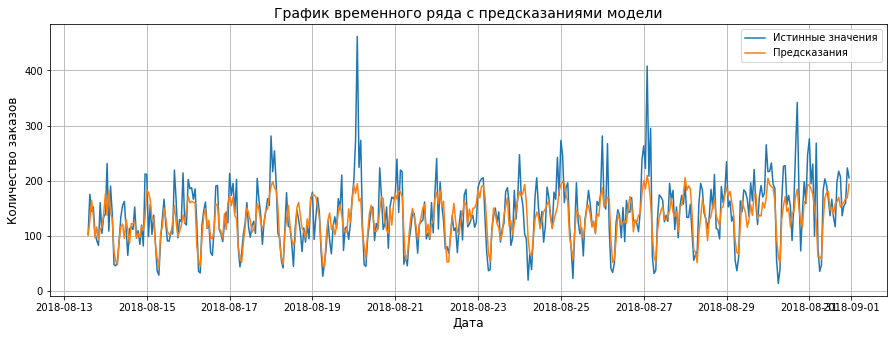

In [71]:
# Построим график истинных значений и предсказаний модели

plt.figure(figsize=(15,5))
plt.plot(check.index, check['num_orders'], label='Истинные значения')
plt.plot(check.index, check['pred'], label='Предсказания')

plt.title('График временного ряда с предсказаниями модели', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.legend()
plt.grid(True)


Тестовая часть данных попала как раз на август, где отмечаются самые высокие показатели числа поездок.

Также есть непонятные всплески 20 и 27 августа 2018 года (это понедельники). Ретроспективно не нашла никаких событий, которые могли бы это объяснить. 

Модель уловила основные закономерности, в целом выглядит довольно не плохо. 

Но пиковые значения (значения выше 200 заказов в час, а также минимальные значения) она не предсказывает.